In [52]:
""" imports """
from otalign.src import bilind
import utils

import time
import os
import collections
from glob import glob
import pickle

import numpy as np
from numpy.linalg import norm

import pandas as pd
from functools import reduce
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
from tqdm import tqdm_notebook as tqdm

import ot

In [53]:
#coupling_dir = "exploring_gwot_freq-info/coupling_1850_1900_2000w/"
#coupling_dir = "exploring_gwot_coupling-sizes/coupling_1850_1900_2000K/"
#coupling_dir = "exploring_gwot/coupling_1800_1900/"
coupling_dir = "exploring_gwot_flat-freq/coupling_1800_1900_2000w/"
coupling, voc1, voc2 = utils.load_coupling("/home/simon/Desktop/thesis/GWOT/outputs/"+coupling_dir)

#### Analyze Pairs by String Match
What's going on in the coupling? Which ones are the translation pairs, how many are found, what are the mismatches? ...?

In [54]:
scored_pairs = utils.scored_mutual_nn(coupling, voc1, voc2)

In [55]:
for rank, (w1, w2) in enumerate(sorted(scored_pairs, key=scored_pairs.get, reverse=True)):
    if w1 != w2:
        print(f"mismatch: {round(scored_pairs[(w1,w2)], 8)}\t{rank}  {w1}  {w2}")
    else:
        print(f"          {round(scored_pairs[(w1,w2)], 8)}\t{rank}  {w1}  {w2}")

          0.00091713	0  the  the
          0.00090104	1  of  of
          0.00083456	2  to  to
          0.00082524	3  a  a
          0.00082148	4  in  in
          0.00079716	5  and  and
          0.00077649	6  by  by
          0.00077566	7  that  that
          0.00075943	8  as  as
          0.00075915	9  be  be
          0.00075631	10  is  is
          0.0007563	11  which  which
          0.0007529	12  was  was
          0.00075163	13  it  it
          0.00074941	14  this  this
          0.00074743	15  for  for
          0.00074577	16  with  with
          0.00074296	17  at  at
          0.00073962	18  from  from
          0.00073335	19  are  are
          0.00070716	20  ,  ,
          0.00070607	21  or  or
          0.00069735	22  have  have
          0.00069502	23  were  were
          0.00069087	24  been  been
          0.00068213	25  these  these
          0.00068002	26  one  one
          0.00067843	27  an  an
          0.00067025	28  than  than
          0.00066979	29  i  i
  

In [56]:
print("vocabulary overlap:",len(set(voc1).intersection(set(voc2))))
print("translation pairs:",len(scored_pairs))

vocabulary overlap: 1316
translation pairs: 1608


In [57]:
match_scores = []
mismatch_scores = []

mismatches = {} # 

for s,t in sorted(scored_pairs, key=scored_pairs.get, reverse=True):
    score = scored_pairs[(s,t)]*1000
    if s!=t:
        mismatch_scores.append(score)
        mismatches.update({(s, t):score})
    else:
        match_scores.append(score)

#for k,v in mismatches.items():
#    print(f"{v}\t{k[0]}   {k[1]}")

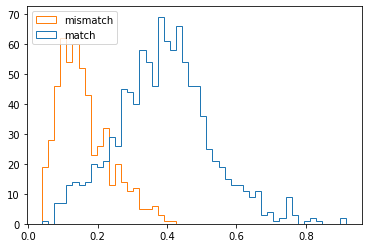

In [59]:
plt.hist([match_scores, mismatch_scores],
         bins=50, #range=(0.0, 0.5), # for 2000 words, 0.0005 is te uniform distribution
         label=['match','mismatch'],
         cumulative=False, histtype="step")
plt.legend(loc='upper left')

### Coupling Confidence
What is a reliable measure for the confidence of a translation pair? In other words: how can we measure the margin by which the highest-scoring coupling value wins over all others? I will look at the following 4 measures:
- entropy among the top 10 scores
- relative size of \#1 to \#2 ("prominence")
- relative size 0f \#1 to the mean score
- relative size of \#1 to the mean of the top 10 scores

If one of these new scores is expressive w.r.t. translation confidence, the match/mismatch histogram should show many matching pairs for high scores and many mismatching pairs for lower confidences.
Note that the pairs are still the same; they are still determined by the coupling's scores. The only difference will be a re-scoring.

In [14]:
def score_scores(coupling, voc1, voc2, method='entropy', top_n=0):
    """
    for each word in the coupling (all rows, all columns), compute a score expressing the 
    top score's margin of 'victory' over other scores. 
    The method 'prominence' relates the best score to the second best score.
    :param method: str -- one of 'entropy', 'prominence', 'mean'
    :param voc1: List[str] -- words of the source space, sorted by index in the space
    :return: Dict[str,float], Dict[str,float] -- words and associated entorpy values
    """
    top_n = 2 if method == 'prominence' else min(coupling.shape) if top_n == 0 else top_n  
    
    # select scores to look at (sorting columns doesn't disturb the rows' order)
    scores1 = np.array([sorted(row, reverse=True)[:top_n] for row in coupling])
    scores2 = np.array([sorted(row, reverse=True)[:top_n] for row in coupling.T])
    
    if method == 'entropy':
        # normalize
        margins1 = np.sum(scores1, axis=1)   
        margins2 = np.sum(scores1, axis=1)
        normed_scores1 = [scores/m for scores,m in zip(scores1, margins1)]
        normed_scores2 = [scores/m for scores,m in zip(scores2, margins2)]
        # calculate entropy
        scores1 = [-sum(scores * np.log(scores)) for scores in normed_scores1] 
        scores2 = [-sum(scores * np.log(scores)) for scores in normed_scores2]
    
    elif method == 'prominence': 
        scores1 = [pair[0]/pair[1] for pair in scores1]
        scores2 = [pair[0]/pair[1] for pair in scores2]
        
    
    elif method == 'mean':
        #for scores in scores1:
        #    print(scores)
        #    print(scores[0])
        #    print(scores.mean())
        #    print("\n")
            
        scores1 = [s[0]/(s.mean()) for s in scores1]
        scores2 = [s[0]/(s.mean()) for s in scores2]
    
    else: 
        print(f"Problem in score_scores(): invalid re-scoring method '{method}'.")
        
    return {w:e for w,e in zip(voc1,scores1)}, {w:e for w,e in zip(voc2,scores2)}
    

In [15]:
take_time = utils.Timer()
ents1, ents2 = score_scores(coupling, voc1, voc2, method='entropy', top_n=10)
take_time("entropy")

proms1, proms2 = score_scores(coupling, voc1, voc2, method='prominence')
take_time("prominence")

means1, means2 = score_scores(coupling, voc1, voc2, method='mean', top_n=10)
take_time("mean")

allmeans1, allmeans2 = score_scores(coupling, voc1, voc2, method='mean')
take_time("total_mean")

print(take_time)

3.98165   entropy
3.84363   prominence
3.96948   mean
4.71734   total_mean


In [16]:
# take the average of each translation pair's words' scores
pair_ents =  {(w1,w2):(ents1[w1]+ents2[w2])/2   for w1,w2 in scored_pairs.keys()}
pair_proms = {(w1,w2):(proms1[w1]+proms2[w2])/2 for w1,w2 in scored_pairs.keys()}
pair_means = {(w1,w2):(means1[w1]+means2[w2])/2 for w1,w2 in scored_pairs.keys()}
pair_allmeans = {(w1,w2):(allmeans1[w1]+allmeans2[w2])/2 for w1,w2 in scored_pairs.keys()}

In [224]:
# bin the scores into matches/mismatches
ent_matches, ent_mismatches = [], []
prom_matches, prom_mismatches = [], []
mean_matches, mean_mismatches = [], []
allmean_matches, allmean_mismatches = [], []

for (s,t), score in pair_ents.items():
    if s!=t: ent_mismatches.append(score)
    else:    ent_matches.append(score)

for (s,t), score in pair_proms.items():
    if s!=t: prom_mismatches.append(score)
    else:    prom_matches.append(score)

for (s,t), score in pair_means.items():
    if s!=t: mean_mismatches.append(score)
    else:    mean_matches.append(score)

for (s,t), score in pair_allmeans.items():
    if s!=t: allmean_mismatches.append(score)
    else:    allmean_matches.append(score)

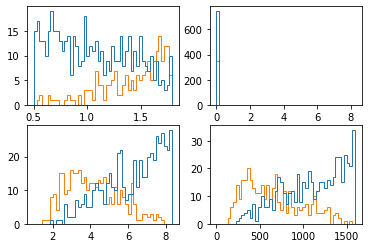

In [240]:
# compute mean and std for better plotting
m_ent,  s_ent  = np.mean(list(pair_ents.values())),     np.std(list(pair_ents.values()))
m_prom, s_prom = np.mean(list(pair_proms.values())),    np.std(list(pair_proms.values()))
m_mean, s_mean = np.mean(list(pair_means.values())),    np.std(list(pair_means.values()))
m_allm, s_allm = np.mean(list(pair_allmeans.values())), np.std(list(pair_allmeans.values()))

#def plot_range(mean,factor,std): return (mean-factor*std, mean+factor*std)

plt.subplot(221)
_ = plt.hist([ent_matches, ent_mismatches], bins=50, 
         label=['ent_match','ent_ismatch'],
         cumulative=False, histtype="step",
         range=(m_ent-1*s_ent, m_ent+1*s_ent))

plt.subplot(222)
_ = plt.hist([prom_matches, prom_mismatches], bins=50, 
         label=['prom_match','prom_mismatch'],
         cumulative=False, histtype="step",
         range=(1, m_prom+1*s_prom)) # the largest value is at least 1* as large as the second largest

plt.subplot(223)
_ = plt.hist([mean_matches, mean_mismatches], bins=50, 
         label=['mean_match','mean_mismatch'],
         cumulative=False, histtype="step",
         range=(1, m_mean+1*s_mean))

plt.subplot(224)
_ = plt.hist([allmean_matches, allmean_mismatches], bins=50, 
         label=['allmean_match','allmean_mismatch'],
         cumulative=False, histtype="step",
         range=(1, m_allm+1*s_allm))

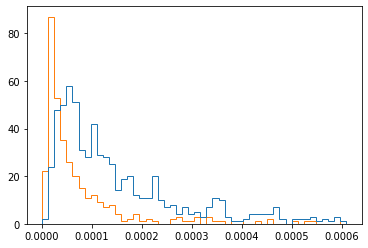

In [232]:
# this is the histogram for the original scores
matches, mismatches = [], []
for (s,t), score in scored_pairs.items():
    if s!=t: mismatches.append(score)
    else:    matches.append(score)

mu, sd = np.mean(list(scored_pairs.values())),np.std(list(scored_pairs.values()))
        
_ = plt.hist([matches, mismatches], bins=50, 
         label=['ent_match','ent_ismatch'],
         cumulative=False, histtype="step",
         range = (0,mu))